In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys
sys.path.append('../common')
from commonfunctions import visualize_cluster_data

In [3]:
# Read the dataset
dataset = pd.read_csv('../Data/data3.csv')
dataset.head(10)

,#,x,y
0,1,10,28
1,2,10,14
2,3,11,12
3,4,11,15
4,5,12,14
5,6,12,11
6,7,13,12
7,8,20,23
8,9,20,25
9,10,20,10


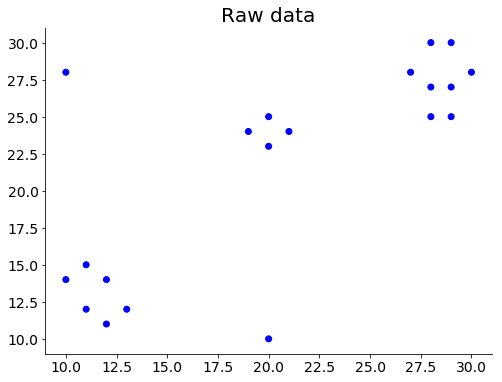

In [4]:
# Select dataset if required
X = dataset.iloc[:, [1,2]].values
clusters = [2] * X.shape[0]
visualize_cluster_data(plt, X, clusters, 'Raw data')


## Calculate the distance between all data points

In [5]:
# Calculate the euclidean distance
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(X, X.shape[0] - 1, mode='distance')
np.set_printoptions(precision=1, suppress=True)
connectivity = connectivity.toarray()
print (connectivity)

[[  0.   14.   16.   13.   14.1  17.1  16.3  11.2  10.4  20.6  11.7  18.2
    9.8  19.1  18.   19.   17.   18.1  19.2  20. ]
 [ 14.    0.    2.2   1.4   2.    3.6   3.6  13.5  14.9  10.8  14.9  21.1
   13.5  24.8  22.2  23.   22.   24.1  22.   24.4]
 [ 16.    2.2   0.    3.    2.2   1.4   2.   14.2  15.8   9.2  15.6  21.4
   14.4  25.5  22.7  23.4  22.6  24.8  22.2  24.8]
 [ 13.    1.4   3.    0.    1.4   4.1   3.6  12.   13.5  10.3  13.5  19.7
   12.   23.4  20.8  21.6  20.6  22.7  20.6  23. ]
 [ 14.1   2.    2.2   1.4   0.    3.    2.2  12.   13.6   8.9  13.5  19.4
   12.2  23.3  20.6  21.4  20.5  22.6  20.2  22.8]
 [ 17.1   3.6   1.4   4.1   3.    0.    1.4  14.4  16.1   8.1  15.8  21.3
   14.8  25.5  22.6  23.3  22.7  24.8  22.   24.8]
 [ 16.3   3.6   2.    3.6   2.2   1.4   0.   13.   14.8   7.3  14.4  19.8
   13.4  24.1  21.2  21.9  21.3  23.4  20.6  23.3]
 [ 11.2  13.5  14.2  12.   12.   14.4  13.    0.    2.   13.    1.4   8.2
    1.4  11.4   8.9   9.8   8.6  10.6   9.2  11.2]


## Algorithm
Instead of creataing a loop to run each step, we will run each iteration one at a time to get a better understanding of the process

In [6]:
# Set parameters

# DBSCAN parameters
eps = 4
min_points = 3

# Mark all data poitns as outliers to begin with. This way when we are done with the algorithm, whatever remains are the outliers
clusters = [-1] * X.shape[0]
current_cluster = 0

# to keep track of indices
indices = np.array(range(X.shape[0]))

Calculate density for each point based on distance <= eps

In [7]:
density = np.sum(connectivity < eps, axis = 1)

Set the most dense point as the start of current cluster

In [8]:
maxIndex = np.argmax(density)
print(density)

[1 6 6 5 6 5 6 4 4 1 4 6 4 6 8 8 8 6 6 8]


If the max density point does not have minimum number of samples, stop the algorithm. Else mark the highest density point in the current cluster

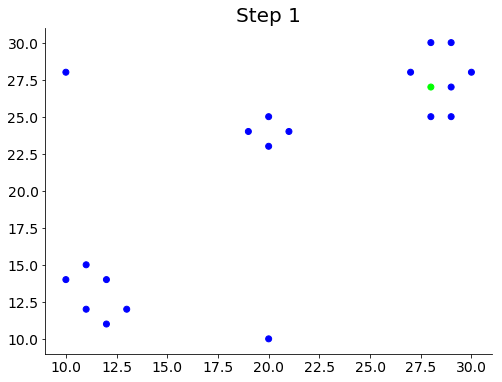

In [9]:
if (density[maxIndex] >= min_points):
    clusters[np.argmax(density)] = current_cluster
else:
    print('Done')
    
# Visualize the data
visualize_cluster_data(plt, X, clusters, 'Step 1', filename = 'DBScanExampleStep1')

Identify neighbours of the current point within eps distance

In [10]:
current_distance = connectivity[maxIndex]
current_indices = indices[current_distance<eps]

If each of these points have minimum sample points around them, mark them for recursive exploration

In [11]:
related_clusters = current_indices[density[current_indices] >= min_points]
print(related_clusters)

[11 13 14 15 16 17 18 19]


For each of the points marked for exploration, if they do not belong to any cluster,
    assign the point to current cluster and 
    identify neighours withing eps distance    

In [12]:
new_relations = []
for c in related_clusters:
    if (clusters[c] == -1): # Only for un allocated points
        clusters[c] = current_cluster
        
        # identify and append the neighbours
        new_distances = connectivity[c]
        new_indices = indices[current_distance<eps]
        new_relations.append(new_indices[density[new_indices] >= min_points])

print(new_relations)

[array([11, 13, 14, 15, 16, 17, 18, 19]), array([11, 13, 14, 15, 16, 17, 18, 19]), array([11, 13, 14, 15, 16, 17, 18, 19]), array([11, 13, 14, 15, 16, 17, 18, 19]), array([11, 13, 14, 15, 16, 17, 18, 19]), array([11, 13, 14, 15, 16, 17, 18, 19]), array([11, 13, 14, 15, 16, 17, 18, 19])]


As all of the 'new relations' have already been allocated to clusters, we are done with this high density area. 

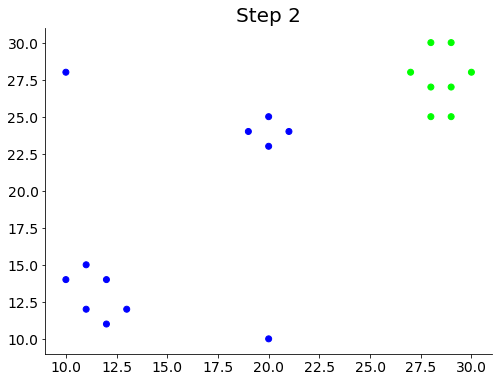

In [13]:
visualize_cluster_data(plt, X, clusters, 'Step 2', filename = 'DBScanExampleStep2')

Start the next iteration with remaining data points. Objective is to find the high density areas from remaining data points

In [14]:
# Start looking for next cluster
current_cluster = current_cluster + 1

# Identify remaining points
remaining_indices = []
i = 0;
for c in clusters:
    if c == -1:
        remaining_indices.append(i)
    i = i+ 1

Identify maximum density point from the remaining points

In [15]:
remaining_density = density[remaining_indices]
maxIndex = remaining_indices[np.argmax(remaining_density)]

If the max density point does not have minimum number of samples, stop the algorithm. Else mark the highest density point in the current cluster

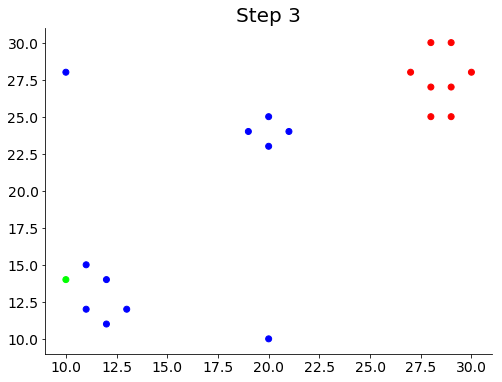

In [16]:
if (density[maxIndex] >= min_points):
    clusters[maxIndex] = current_cluster
else:
    print('Done')

# Visualize data    
visualize_cluster_data(plt, X, clusters, 'Step 3', filename = 'DBScanExampleStep3')

Identify neighbours of the current point within eps distance

In [17]:
current_distance = connectivity[maxIndex]
current_indices = indices[current_distance<eps]

If each of these points have minimum sample points around them, mark them for recursive exploration

In [18]:
related_clusters = current_indices[density[current_indices] >= min_points]
print(related_clusters)

[1 2 3 4 5 6]


For each of the points marked for exploration, if they do not belong to any cluster,
    assign the point to current cluster and 
    identify neighours withing eps distance   

In [19]:
new_relations = []
for c in related_clusters:
    if (clusters[c] == -1):
        clusters[c] = current_cluster # Only for unallocated points
        
        # identify and append the neighbours
        new_distances = connectivity[c]
        new_indices = indices[current_distance<eps]
        new_relations.append(new_indices[density[new_indices] >= min_points])

print(new_relations)

[array([1, 2, 3, 4, 5, 6]), array([1, 2, 3, 4, 5, 6]), array([1, 2, 3, 4, 5, 6]), array([1, 2, 3, 4, 5, 6]), array([1, 2, 3, 4, 5, 6])]


As all of the 'new relations' have already been allocated to clusters, we are done with this high density area. 

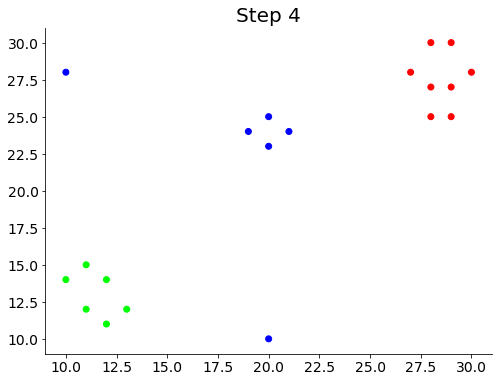

In [20]:
# Visualize the data
visualize_cluster_data(plt, X, clusters, 'Step 4', filename = 'DBScanExampleStep4')

Start the next iteration with remaining data points. Objective is to find the high density areas from remaining data points

In [21]:
# Start looking for next cluster
current_cluster = current_cluster + 1

# Indentify remaining data points
remaining_indices = []
i = 0;
for c in clusters:
    if c == -1:
        remaining_indices.append(i)
    i = i+ 1

Identify maximum density point from the remaining points

In [22]:
remaining_density = density[remaining_indices]
maxIndex = remaining_indices[np.argmax(remaining_density)]

If the max density point does not have minimum number of samples, stop the algorithm. Else mark the highest density point in the current cluster

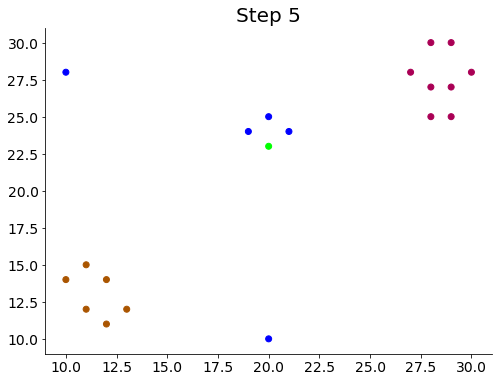

In [23]:
if (density[maxIndex] >= min_points):
    clusters[maxIndex] = current_cluster
else:
    print('Done')
visualize_cluster_data(plt, X, clusters, 'Step 5', filename = 'DBScanExampleStep5')

Identify neighbours of the current point within eps distance

In [24]:
current_distance = connectivity[maxIndex]
current_indices = indices[current_distance<eps]

If each of these points have minimum sample points around them, mark them for recursive exploration

In [25]:
related_clusters = current_indices[density[current_indices] >= min_points]
print(related_clusters)

[ 7  8 10 12]


For each of the points marked for exploration, if they do not belong to any cluster,
    assign the point to current cluster and 
    identify neighours withing eps distance   

In [26]:
new_relations = []
for c in related_clusters:
    if (clusters[c] == -1):
        clusters[c] = current_cluster
        new_distances = connectivity[c]
        new_indices = indices[current_distance<eps]
        new_relations.append(new_indices[density[new_indices] >= min_points])

print(new_relations)

[array([ 7,  8, 10, 12]), array([ 7,  8, 10, 12]), array([ 7,  8, 10, 12])]


As all of the 'new relations' have already been allocated to clusters, we are done with this high density area. 

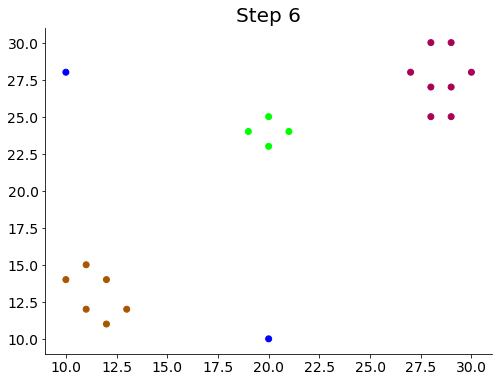

In [27]:
visualize_cluster_data(plt, X, clusters, 'Step 6', filename = 'DBScanExampleStep6')

Start the next iteration with remaining data points. Objective is to find the high density areas from remaining data points

In [28]:
# Start looking for next cluster
current_cluster = current_cluster + 1

# Indentify remaining data points
remaining_indices = []
i = 0;
for c in clusters:
    if c == -1:
        remaining_indices.append(i)
    i = i+ 1

Identify maximum density point from the remaining points

In [29]:
remaining_density = density[remaining_indices]
maxIndex = remaining_indices[np.argmax(remaining_density)]

If the max density point does not have minimum number of samples, stop the algorithm. Else mark the highest density point in the current cluster

In [30]:
if (density[maxIndex] >= min_points):
    clusters[maxIndex] = current_cluster
else:
    print('Done')

Done


As the remaining data points do not have the minimum required density, they will remain outliers and we will terminate the algorithm

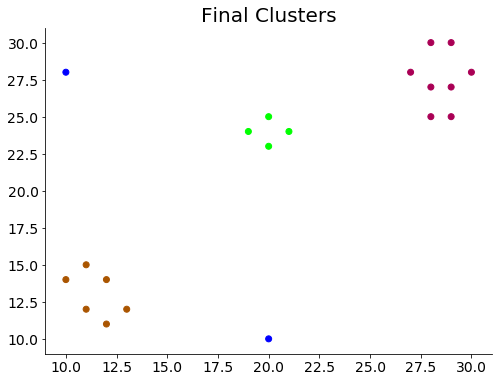

In [31]:
visualize_cluster_data(plt, X, clusters, 'Final Clusters', filename = 'DBScanExampleStep7')